In [9]:
from datasets import load_dataset
import numpy as np
from sklearn.svm import SVC
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import pos_tag
import pickle

In [12]:
stopwords = stopwords.words('english')
print(list(stopwords))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [13]:
pos_tags = [ 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 
            'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 
            'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'
           ]

In [14]:
data = load_dataset("conll2003")
data

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [15]:
d_train = data['train']
d_validation = data['validation']
d_test = data['test']

In [16]:
# Vector = [title, isStopWord, allCaps, length, isDigit, prevWord_POS_Tag(36 tags one hot encoding), next_word_POS_tag, current_word_POS_tag]
def feature_vector(word, prev_word_pos_tag, next_word_pos_tag, current_word_pos_tag):
    vec = np.zeros(116).astype('float32')
    
    # Check if word is a title
    if(word.istitle()):
        vec[0] = 1
    
    # Check if word is stopword
    if word.lower() in stopwords:
        vec[1] = 1
        
    #Check if all the letters are capital
    if(word.isupper()):
        vec[2] = 1
    
    # Length of word
    vec[3] = len(word)
    
    #Check if the word is a number
    vec[4] = word.isdigit()
    
    #One hot encode tag of prev word
    idx = prev_word_pos_tag if isinstance(prev_word_pos_tag, int) and prev_word_pos_tag!=-1 else prev_word_pos_tag
    vec[5+idx] = 1
    
    #One hot encode tag of next word
    idx = next_word_pos_tag if isinstance(next_word_pos_tag, int) and current_word_pos_tag!=-1 else next_word_pos_tag
    vec[41+idx] = 1
    
    #One hot encode tag of current word
    idx = current_word_pos_tag if isinstance(current_word_pos_tag, int) else current_word_pos_tag
    vec[77+idx] = 1
    
    return vec

In [19]:
# This function is used to make dataset with features and target label
def create_data(data):
    x_train = []
    y_train = []
    for x in data:
        for y in range(len(x['tokens'])):
            prev_pos = -1 if y==0 or x['pos_tags'][y-1]<10 else x['pos_tags'][y-1]
            next_pos = -1 if y==len(x['tokens'])-1 or x['pos_tags'][y-1]<10 else x['pos_tags'][y+1]
            current_pos = -1 if x['pos_tags'][y]<10 else x['pos_tags'][y]
            wordVec = feature_vector(x['tokens'][y], prev_pos-10, next_pos-10, current_pos-10)
            x_train.append(wordVec)
            y_train.append(1 if x['ner_tags'][y]!=0 else 0)
        
    return x_train, y_train

In [20]:
x_train, y_train = create_data(d_train)

In [21]:
print(len(x_train))
print(len(y_train))

203621
203621


In [24]:
# Train the model
# uncomment .fit when training
clf = SVC(verbose=True)
#clf.fit(x_train, y_train)

In [25]:
# saving model
filename = "/home/sarvam/Documents/cs_626/Assignments/assignment_3_ner_svm/svm_ner.pkl"
pickle.dump(clf, open(filename, 'wb'))

In [26]:
clf = pickle.load(open(filename, 'rb'))

/home/sarvam/.local/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [27]:
x_val, y_val = create_data(d_validation)

In [28]:
y_val_pred = clf.predict(x_val)

In [29]:
print(classification_report(y_true=y_val, y_pred=y_val_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     42759
           1       0.89      0.93      0.91      8603

    accuracy                           0.97     51362
   macro avg       0.94      0.95      0.94     51362
weighted avg       0.97      0.97      0.97     51362



In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
conf_mat = confusion_matrix(y_val, y_val_pred)

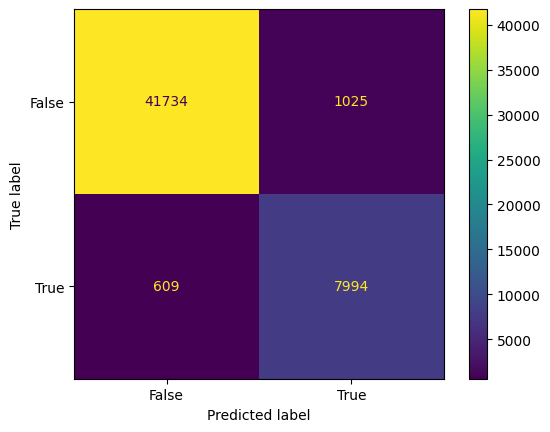

In [31]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = [False, True])

cm_display.plot()
plt.show()

In [32]:
def predict_ner(feature_vec):
    pred = clf.predict([feature_vec])
    return pred

In [38]:
input_sent = examples = [
    "Delhi is the capital of India.",
    "US Vice President Kamala Harris, PM Modi talk up Indo-US ties at 1st in-person meeting.",
    "Covid-19 India Live News: National Task Force drops Ivermectin, HCQ drugs from Covid-19 treatment protocol; India logs 31,382 new cases.",
    "USA Rules Out Adding India Or Japan To Security Alliance With Australia And UK", # all words are capitalized
]

for input_s in input_sent:
    sent = word_tokenize(input_s)
    sent_pos_tags = pos_tag(sent)

    for idx, word in enumerate(sent):
        prev_tag = -1 if idx==0 else sent_pos_tags[idx-1][1]
        next_tag = -1 if idx==len(sent)-1 else sent_pos_tags[idx+1][1]
        current_tag = sent_pos_tags[idx][1]
        prev_idx = pos_tags.index(prev_tag) if prev_tag in pos_tags else -1
        next_idx = pos_tags.index(next_tag) if next_tag in pos_tags else -1
        current_idx = pos_tags.index(current_tag) if current_tag in pos_tags else -1
        vec = feature_vector(word, prev_idx, next_idx, current_idx)
        y_pred = predict_ner(vec)
        print(word+"_"+str(y_pred[0]), end=" ")
    print()
    print()

Delhi_1 is_0 the_0 capital_0 of_0 India_1 ._0 

US_1 Vice_1 President_1 Kamala_1 Harris_1 ,_0 PM_1 Modi_1 talk_0 up_0 Indo-US_0 ties_0 at_0 1st_0 in-person_0 meeting_0 ._0 

Covid-19_1 India_1 Live_1 News_1 :_0 National_1 Task_1 Force_1 drops_0 Ivermectin_1 ,_0 HCQ_1 drugs_0 from_0 Covid-19_1 treatment_0 protocol_0 ;_0 India_1 logs_0 31,382_0 new_0 cases_0 ._0 

USA_1 Rules_1 Out_1 Adding_1 India_1 Or_1 Japan_1 To_0 Security_1 Alliance_1 With_1 Australia_1 And_1 UK_1 

